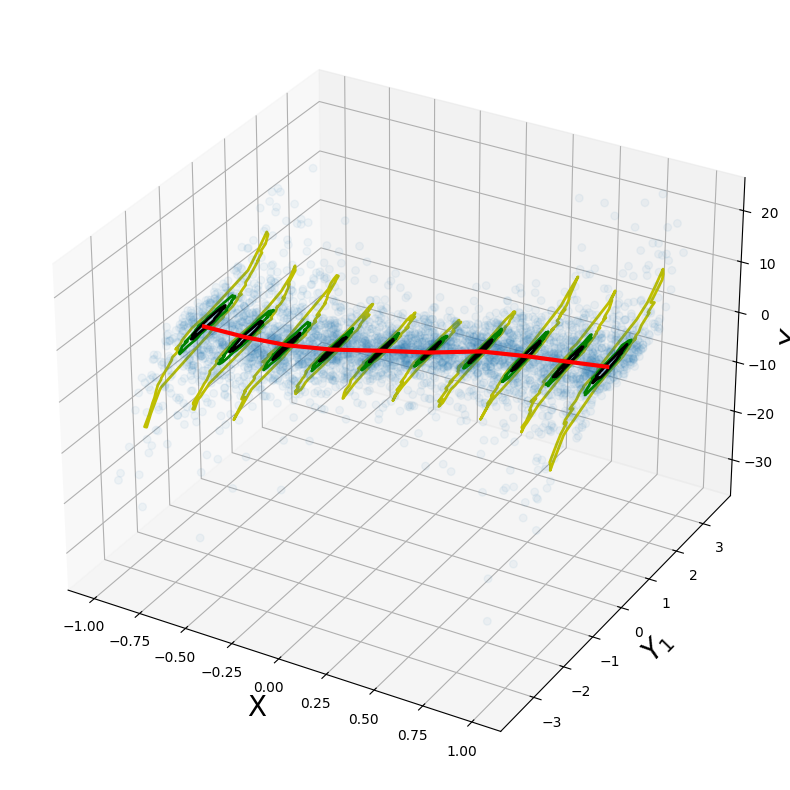

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ot
import math
import time

from scipy.spatial import distance_matrix
#from matplotlib import interactive
#interactive(True)

def QuantileKn(x, y, z, nR, nS, grid,k):
    ### x=covariates 1D
    ### (y,z)=output variables
    ### n=nR*nS+1 number of neighbors
    ### grid=size of partition of the x-space
    ### k number of points in quantile contour

    ## uniform grid
    n = nR*nS+1
    U = np.zeros((n, 2))
    radii = np.linspace(1 / (nS + 1), nS / (nS + 1), nS, endpoint=True)
    w = np.ones(n)
    ## define variables
    center = np.zeros((grid, 3))
    quantile1 = np.zeros((k * grid, 3))
    quantile2 = np.zeros((k * grid, 3))
    quantile3 = np.zeros((k * grid, 3))

    l = -1
    for i in range(nS):
        angle = 2 * np.pi * np.linspace(0, 1 - 1 / nR, nR, endpoint=True)
        for j in range(nR):
            l += 1
            U[l, :] = [radii[i] * np.cos(angle[j]), radii[i] * np.sin(angle[j])]
    U[-1, :] = [0, 0]

    ## x mesh
    xmin = x.min()
    xmax = x.max()
    x_tick = np.linspace(xmin+0.5*(xmax-xmin)/grid,xmax-0.5*(xmax-xmin)/grid,grid)

    ## Compute quantile contours
    for i in range(grid):
        X = np.zeros(n)
        ### select n-nearest neighbors
        order = np.argsort(np.abs(x - x_tick[i]))
        xx = x[order]
        X = xx[:n]
        yy = y[order]
        Y = yy[:n]
        zz = z[order]
        Z = zz[:n]
        a = np.zeros((n, 2))
        for j in range(n):
            a[j, :] = [Y[j], Z[j]]

        ## computation of cost matrix
        cost = distance_matrix(x=U, y=a, p=2) ** 2
        ## optimal transport
        Pn, log = ot.emd(w, w, cost, log=True, numItermax=100000000)
        new_index = (Pn @ np.arange(n)).astype('int32')
        sample_sort = a[new_index]

        ## renormalization
        ysup = max(np.linalg.norm(sample_sort, axis=1))
        xxx = U / ysup
        yyy = sample_sort / ysup

        ## Karp's algorithm for computing the weights
        xiyi = (xxx * yyy) @ np.ones(shape=(2, 1))
        cij = xiyi @ np.ones(shape=(1, n)) - xxx @ yyy.T
        for u in range(n):
            cij[u,u] = math.inf

        dij = np.zeros(shape=(n + 1, n))
        dij[0, :] = math.inf
        dij[0, 0] = 0
        for kk in range(1, n + 1):
            for u in range(n):
                dij[kk, u] = min(dij[(kk - 1), :] + cij[:, u])

        dndk = np.zeros(n)
        denom = (np.zeros(n) + n) - list(range(n))

        for u in range(n):
            dndk[u] = max((dij[n, u] - dij[:-1, u]) / denom)
        e_star = min(dndk)

        mat1 = np.arange(0, n + 1)
        mat1.shape = (n + 1, 1)
        mat2 = np.ones(n)
        mat2.shape = (1, n)

        di_tilde = (dij - e_star * mat1 @ mat2).min(axis=0)
        psi = -di_tilde * ysup ** 2
        e0 = abs(e_star) * ysup ** 2 / 2

        def T0(x):
            scores = sample_sort @ x
            scores.shape = n
            scores = scores - psi
            indice = scores.argmax()
            return sample_sort[indice, :]

        aux = T0(np.zeros(shape=(2, 1)))
        center[i, :] = [x_tick[i],aux[0],aux[1]]

        ### Quantiles
        for l in range(k):
            xtemp = np.ones(shape=(2, 1))
            xtemp[0] = math.cos(2 * l * math.pi / k)
            xtemp[1] = math.sin(2 * l * math.pi / k)
            aux=T0(0.2*xtemp)
            quantile1[k * i + l, :] = [x_tick[i], aux[0],aux[1]]
            aux = T0(0.4 * xtemp)
            quantile2[k * i + l, :] = [x_tick[i], aux[0],aux[1]]
            aux = T0(0.8 * xtemp)
            quantile3[k * i + l, :] = [x_tick[i], aux[0],aux[1]]

    return quantile1, quantile2, quantile3, center


def PlotQuantile3D(x , y, z,quantile, quantile2,quantile3,center,NumberOfGrid,ContourLength):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.scatter3D(x, y, z, s=30,alpha=0.05)
    ax.set_xlabel('X',fontsize=20)
    ax.set_ylabel('$Y_1$',fontsize=20)
    ax.set_zlabel('$Y_2$',fontsize=20)
    #Plot the centers
    ax.plot3D(center[:,0],center[:,1],center[:,2], 'r',alpha = 1, linewidth=3.0,zorder=5)
    for k in range(NumberOfGrid):
        si=ContourLength
        r1=k*(si)
        r2=(si)*(k+1)
        q1=np.zeros((si+1,3))
        q1[0:si,:]=quantile[r1:r2,:]
        q1[si,:]=quantile[r1,:]
        ax.plot3D(q1[:,0],q1[:,1],q1[:,2],'k-',alpha = 1, linewidth=2.0,zorder=4)
        q1=np.zeros((si+1,3))
        q1[0:si,:]=quantile2[r1:r2,:]
        q1[si,:]=quantile2[r1,:]
        ax.plot3D(q1[:,0],q1[:,1],q1[:,2],'g-',alpha = 1, linewidth=2.0,zorder=3)
        q1=np.zeros((si+1,3))
        q1[0:si,:]=quantile3[r1:r2,:]
        q1[si,:]=quantile3[r1,:]
        ax.plot3D(q1[:,0],q1[:,1],q1[:,2],'y-',alpha = 1, linewidth=2.0,zorder=2)
    plt.show()

## example with simulated data
nn=20
n_sample = (nn** 2 + 1) * 10
x = (4 * np.random.random(n_sample) - 2) / 2  # *3/2
y = np.zeros(n_sample)
z = np.zeros(n_sample)
Id = np.array([[1, 0], [0, 1]])
for i in range(n_sample):
    u = (1 + 3 / 2 * np.sin(np.pi * x[i] / 2) ** 2)
    s = 0.5
    xt = np.sqrt(u) * ot.datasets.make_2D_samples_gauss(1, 0, Id)
    # s=
    y[i] = np.sin(np.pi * x[i] * 0.65) + s * xt[:, 0] * 1.15
    z[i] = np.cos(np.pi * x[i] * 0.65) + x[i] ** 2 + s * (
                xt[:, 1] / 1.15 + 0.5 * ((xt[:, 0]) ** 3 + 8 * (x[i] ** 4 * 1.15 ** 2)))

quantile1, quantile2, quantile3, center=QuantileKn(x,y,z,nn,nn,10,100)
PlotQuantile3D(x,y,z,quantile1, quantile2, quantile3, center,10,100)